# Exploratory Data Analysis

## Objetivo del análisis
Comprender las caracteristicas de los clientes que solicitan crédito y analizar los factores asociados al riesgo de incumplimiento. Se busca identificar patrones, relaciones entre variables y posibles problemas en los datos que podrían afectar el desempeño de futuros modelos en la predicción de riesgo crediticio.

## Descripción de Dataset
Para el presente proyecto se utiliza el dataset **Home Credit Default Risk**, proveniente de la competencia Kaggle del mismo nombre.

Este dataset contiene información de solicitantes de crédito incluyendo:
- Datos socioeconómicos
- Información laboral
- Detalles del crédito solicitado
- Historial Financiero
- Variables categóricas y numéricas relacionadas con estabilidad y capacidad de pago.

El dataset principal que se analizará es:
- **aplication_train.csv**
  + Cada fila representa a un cliente que aplico a un crédito.
  + Contiene variables explicativas y la variable objetivo (TARGET) que indica.
    * 0: si el no cliente incumplió el pago del crédito.
    * 1: si el cliente incumpló el pago del crédito.

El propósito final será construir un modelo capaz de predecir esta variable, y en este notebook se comprenderá el comportamiento y qué factores están asociados al incumplimiento.

In [177]:
#### Librerías ####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb

# Comando para hacer que las columnas del data frame se muestren sin ser truncadas
pd.set_option("display.max_columns", None)

### Cargar dataset principal

In [135]:
train = pd.read_csv("../data/raw/application_train.csv")

# Se exploran el tamaño del dataset
train.shape

(307511, 122)

### Análisis de la variable objetivo (TARGET)

        clase  num_clientes  proporcion
0     default         24825         8.0
1  no_default        282686        92.0


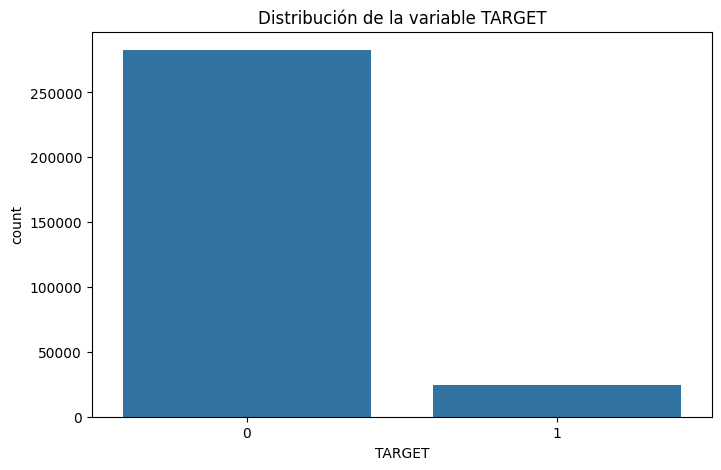

In [120]:
#### Distribución de la variable objetivo ####
dist_target = (
    train
    .assign(clase = lambda x: np.where(x["TARGET"] == 0, "no_default", "default"))
    .groupby("clase", as_index = False)
    .agg(num_clientes = ("TARGET", "count"))
    .assign(proporcion = lambda x: ((x["num_clientes"] / x["num_clientes"].sum()) * 100).round())
)

print(dist_target)

#### Visualización ####
plt.figure(figsize = (8, 5))
sns.countplot(x = train["TARGET"])
plt.title("Distribución de la variable TARGET")
plt.show()

La tabla de frecuencias y la gráfica de distribución muestran cuantos clientes han incumplido sus obligaciones crediticias (TARGET = 1) en comparación con aquellos que sí cumplen (TARGET = 0).

Se observa que la mayoría de los registros pertenecen a la clase 0 con una proporción del 92%, mientras que solo una proporción pequeña  del 8% corresponde a clientes en incumplimiento. Esto significa que el dataset está desbalanceado, lo cual es un comportamiento esperable en escenarios reales, ya que normalmente son más los clientes que pagan que los que fallan.

### Diagnóstico de Calidad de Datos

In [121]:
# Se realiza el análisis unicamente de la variables que no son objetivo
train_diagnosis = train.drop(columns = "TARGET")

# Se inicializa la tabla disgnositico
summary = []

for col in train_diagnosis.columns:

    unicos = train_diagnosis[col].nunique()

    # Información básica y nulos
    stats = {
        "columna": col,
        "tipo": train_diagnosis[col].dtype, 
        "nulos": train_diagnosis[col].isnull().sum(), 
        "%_nulos": ((train_diagnosis[col].isnull().sum() / len(train_diagnosis)) * 100).round(2), 
        "unicos": unicos, 
        "media": pd.NA, "std": pd.NA, 
        "cat_dominante": pd.NA, "prop_binaria": pd.NA
    }

    # Valores Constantes
    stats['es_constante'] = stats['unicos'] <= 1

    # Outliers (sólo para columnas numericas)
    if pd.api.types.is_numeric_dtype(train_diagnosis[col]):

        # Se calcula la media y la desviación estandar
        stats["media"] = train_diagnosis[col].mean().round(2)
        stats["std"] = train_diagnosis[col].std().round(2)

        # Se calculan los outliers utilizando el rango intercuartil
        Q1 = train_diagnosis[col].quantile(0.25)
        Q3 = train_diagnosis[col].quantile(0.75)
        IQR = Q3 - Q1
        bajo = Q1 - 1.5 * IQR
        alto = Q3 + 1.5 * IQR
        outliers = train_diagnosis[(train_diagnosis[col] < bajo) | (train_diagnosis[col] > alto)][col].count()

        # Se asigna la información en la tavla stats
        stats['num_outliers'] = outliers

    else:

        # Categorías raras (Categorías que aparecen menos del 1% de las veces)
        frecuencias = train_diagnosis[col].value_counts(normalize = True)
        if not frecuencias.empty:
            if frecuencias.iloc[0] > 0.90:
                stats["cat_dominante"] = round(frecuencias.iloc[0]*100, 2)
        
        raros = frecuencias[frecuencias < 0.01].count()
        stats['num_outliers'] = "N/A"

    ## Proporciones Binarias
    if unicos == 2:
        perc_1 = round(frecuencias.iloc[0] * 100, 2)
        perc_2 = round(frecuencias.iloc[1] * 100, 2)
        stats['prop_binaria'] = np.maximum(perc_1, perc_2)

    summary.append(stats)

# Se genera el data frame
train_summary = pd.DataFrame(summary).assign(CV = lambda x: (x["std"] / x["media"]).abs())

print(f"Filas duplicadas totales: {train_summary.duplicated().sum()}")
print(f"Valores constantes: {len(train_summary.loc[lambda x: x['es_constante'] == True])}")
    

Filas duplicadas totales: 0
Valores constantes: 0


### Reducción Inicial de Variables

**A. Variables con demasiados nulos**

In [122]:
train_summary = train_summary.assign(
    candidata = lambda x: np.select(
        [x["%_nulos"] > 70, x["%_nulos"] > 60], 
        ["eliminar", "observar"], default = "conservar"
    )
)

train_summary.loc[lambda x: x["%_nulos"] > 60]


,columna,tipo,nulos,%_nulos,unicos,media,std,cat_dominante,prop_binaria,es_constante,num_outliers,CV,candidata
20,OWN_CAR_AGE,float64,202929,65.99,62,12.06,11.94,<NA>,<NA>,False,4932,0.99005,observar
46,YEARS_BUILD_AVG,float64,204488,66.50,149,0.75,0.11,<NA>,<NA>,False,2154,0.146667,observar
47,COMMONAREA_AVG,float64,214865,69.87,3181,0.04,0.08,<NA>,<NA>,False,7942,2.0,observar
51,FLOORSMIN_AVG,float64,208642,67.85,305,0.23,0.16,<NA>,<NA>,False,343,0.695652,observar
53,LIVINGAPARTMENTS_AVG,float64,210199,68.35,1868,0.1,0.09,<NA>,<NA>,False,7881,0.9,observar
55,NONLIVINGAPARTMENTS_AVG,float64,213514,69.43,386,0.01,0.05,<NA>,<NA>,False,15580,5.0,observar
60,YEARS_BUILD_MODE,float64,204488,66.50,154,0.76,0.11,<NA>,<NA>,False,2537,0.144737,observar
61,COMMONAREA_MODE,float64,214865,69.87,3128,0.04,0.07,<NA>,<NA>,False,7938,1.75,observar
65,FLOORSMIN_MODE,float64,208642,67.85,25,0.23,0.16,<NA>,<NA>,False,320,0.695652,observar
67,LIVINGAPARTMENTS_MODE,float64,210199,68.35,736,0.11,0.1,<NA>,<NA>,False,7469,0.909091,observar


Se observa que las variables con los sufijos AGE, AVG, MODE y MEDI presentan mpas del 60% de valores nulos. Sin embargo, estos errores faltantes no corresponden a errores de captura sino a la ausencia de información por no aplicar a ciertos clientes. Dado que estas variables suelen ser relevantes en modelos de riesgo, no se eliminan en esta fase. Se evaluará posteriormente si aportan valor predictivo o si su implementación afecta negativamente al modelo.

**B. Valores casi constantes**

In [123]:
#### Análisis de variables binarias ####
train_summary = train_summary.assign(
    candidata = lambda x: np.select(
        [ 
            x["unicos"] != 2,
            x["columna"].str.contains("FLAG_DOCUMENT"), 
            (90 <= x["prop_binaria"]) & (x["prop_binaria"] < 97), 
            (x["prop_binaria"] >= 97)
        ], 
        [x["candidata"], "observar", "observar", "eliminar"], default = "conservar"
    )
)

train_summary.loc[lambda x: x["unicos"] == 2]

,columna,tipo,nulos,%_nulos,unicos,media,std,cat_dominante,prop_binaria,es_constante,num_outliers,CV,candidata
1,NAME_CONTRACT_TYPE,object,0,0.0,2,<NA>,<NA>,90.48,90.48,False,N/A,<NA>,observar
3,FLAG_OWN_CAR,object,0,0.0,2,<NA>,<NA>,<NA>,65.99,False,N/A,<NA>,conservar
4,FLAG_OWN_REALTY,object,0,0.0,2,<NA>,<NA>,<NA>,69.37,False,N/A,<NA>,conservar
21,FLAG_MOBIL,int64,0,0.0,2,1.0,0.0,<NA>,88.73,False,1,0.0,conservar
22,FLAG_EMP_PHONE,int64,0,0.0,2,0.82,0.38,<NA>,88.73,False,55386,0.463415,conservar
23,FLAG_WORK_PHONE,int64,0,0.0,2,0.2,0.4,<NA>,88.73,False,61308,2.0,conservar
24,FLAG_CONT_MOBILE,int64,0,0.0,2,1.0,0.04,<NA>,88.73,False,574,0.04,conservar
25,FLAG_PHONE,int64,0,0.0,2,0.28,0.45,<NA>,88.73,False,0,1.607143,conservar
26,FLAG_EMAIL,int64,0,0.0,2,0.06,0.23,<NA>,88.73,False,17442,3.833333,conservar
33,REG_REGION_NOT_LIVE_REGION,int64,0,0.0,2,0.02,0.12,<NA>,17.53,False,4657,6.0,conservar


*Variables Binarias*

Se identificaron variables con una proporción muy alta de un único valor. En particular, las variables **FLAG_DOCUMENT** muestran distribuciones altamente desbalanceadas, mientras que **EMERGECY_STATE_MODE** presenta practicamente un único valor ("No") más valores nulos.

En esta etapa, **EMERGECY_STATE_MODE** se elimina debido a su falta de clara variabilidad y relevancia análitica.

En el caso de las variables **FLAG_DOCUMENT**, aunque presentan baja variabilidad, podrían contener información relevante para el riesgo crediticio. Por ello, se mantienen temproalmente y su utilidad será evaludada en el análisis de relación con el target antes de una eliminación definitiva.

In [124]:
#### Variables Categoricas ####
train_summary = train_summary.assign(candidata = lambda x: np.select(
    [
        x["candidata"] != "conservar",
        (x["unicos"] != 2) & (x["cat_dominante"] > 97), 
        (x["unicos"] != 2) & (x["cat_dominante"] < 97)
    ], 
    [x["candidata"], "eliminar", "observar"], default = x["candidata"]
))

train_summary.loc[lambda x: ~(x["cat_dominante"].isna()) & (x["unicos"] != 2)]

,columna,tipo,nulos,%_nulos,unicos,media,std,cat_dominante,prop_binaria,es_constante,num_outliers,CV,candidata
86,HOUSETYPE_MODE,object,154297,50.18,3,<NA>,<NA>,98.23,<NA>,False,N/A,<NA>,eliminar


*Variables Categoricas*

Se analizaron las variables categoricas para identificar aquellas con una categoría dominante. Variables donde una sola catergoría concentra más del 97% de los registros presentan una variabilidad extremadamente baja, lo que limita la capacidad para aprtar información útil al modelo.

En este caso, la varuable se considera candidata a eliminación.

In [125]:
train_summary = train_summary.assign(candidata = lambda x: np.select(
    [
        x["candidata"] != "conservar", 
        (x["unicos"] != 2) & (x["CV"] < 0.05), 
        (x["unicos"] != 2) & (0.05 <= x["CV"]) & (x["CV"] < 0.15)
    ], 
    [x["candidata"], "eliminar", "observar"], default = "conservar"
))

train_summary.loc[lambda x: ~(x["CV"].isna()) & (x["unicos"] != 2)].sort_values("CV")

,columna,tipo,nulos,%_nulos,unicos,media,std,cat_dominante,prop_binaria,es_constante,num_outliers,CV,candidata
73,YEARS_BEGINEXPLUATATION_MEDI,float64,150007,48.78,245,0.98,0.06,<NA>,<NA>,False,4762,0.061224,observar
59,YEARS_BEGINEXPLUATATION_MODE,float64,150007,48.78,221,0.98,0.06,<NA>,<NA>,False,5074,0.061224,observar
45,YEARS_BEGINEXPLUATATION_AVG,float64,150007,48.78,285,0.98,0.06,<NA>,<NA>,False,4784,0.061224,observar
60,YEARS_BUILD_MODE,float64,204488,66.50,154,0.76,0.11,<NA>,<NA>,False,2537,0.144737,observar
74,YEARS_BUILD_MEDI,float64,204488,66.50,151,0.76,0.11,<NA>,<NA>,False,2274,0.144737,observar
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,NONLIVINGAPARTMENTS_MODE,float64,213514,69.43,167,0.01,0.05,<NA>,<NA>,False,14224,5.0,observar
55,NONLIVINGAPARTMENTS_AVG,float64,213514,69.43,386,0.01,0.05,<NA>,<NA>,False,15580,5.0,observar
117,AMT_REQ_CREDIT_BUREAU_WEEK,float64,41519,13.50,9,0.03,0.2,<NA>,<NA>,False,8536,6.666667,conservar
115,AMT_REQ_CREDIT_BUREAU_HOUR,float64,41519,13.50,5,0.01,0.08,<NA>,<NA>,False,1626,8.0,conservar


*Varibales Numéricas*

Para analizar la capacidad informativa de las variables numéricas, se evaluó su variabilidad mediante el Coeficiente de Variación (CV), definido como la relación entre la desviación estándar y la media de cada variable. El CV permite medir la dispersión relativa independientemente de la escala, lo que lo convierte en un indicador adecuado para identificar variables con comportamiento prácticamente constante.

En este análisis, se consideraron como candidatas a eliminación aquellas variables con CV muy bajo (menor a 0.05), ya que una variabilidad extremadamente reducida implica escasa capacidad discriminativa y, por lo tanto, bajo aporte potencial al modelo. Sin embargo, tras aplicar este criterio y revisar los resultados con criterio de negocio, no se identificaron variables numéricas continuas que justificaran eliminación en esta etapa, por lo que se mantienen para su evaluación posterior respecto al TARGET.

In [127]:
train_summary.loc[lambda x: x["candidata"] == "eliminar"]

,columna,tipo,nulos,%_nulos,unicos,media,std,cat_dominante,prop_binaria,es_constante,num_outliers,CV,candidata
86,HOUSETYPE_MODE,object,154297,50.18,3,<NA>,<NA>,98.23,<NA>,False,N/A,<NA>,eliminar
89,EMERGENCYSTATE_MODE,object,145755,47.40,2,<NA>,<NA>,98.56,98.56,False,N/A,<NA>,eliminar


*Variables eliminadas tras el análisis de variabilidad*

Después de evaluar la variabilidad tanto de variables numéricas mediante el Coeficiente de Variación (CV), como de variables categóricas a través de su distribución de frecuencias, se identificaron columnas con información prácticamente constante o con muy baja diversidad de valores, lo cual limita significativamente su capacidad explicativa y aporte potencial al modelo.

En particular, las variables **HOUSETYPE_MODE** y **EMERGENCYSTATE_MODE** presentan una alta concentración en una sola categoría y una variabilidad prácticamente nula. Esto implica que no ofrecen capacidad discriminativa relevante ni contribuyen a diferenciar adecuadamente entre las observaciones.

Por lo anterior, ambas columnas se consideran redundantes y se eliminan del conjunto de datos para mejorar la eficiencia del modelo sin afectar la calidad de la información disponible.

## Análisis Exploratorio Estructurado

El objetivo de está sección es identificar qué variables realmente tienen relación con el incumplimiento de pago (TARGET) y, por lo tanto, cuáles merecen mayor atención en etapas posteriores del proyecto.

Se realizará un EDA guiado por relevancia predictiva, es decir, priorizando aquellas variables que potencialmete aportan mayor información para explicar o predecir el default.

Se dividirá el análisis en dos fases:

### Fase 1: Ranking Estadístico de Variables:

Para esta fase, se utilizará la métrica **Mutual Information (MI)**, la cual evalúa cuanta información aporta una variable sobre el TARGET, sin asumir relaciones lineales y permitiendo capturar dependencias complejas. En otras palabras, mide que tanto saber el valor de la variable ayuda a reducir la incertidumbre sobre si un cliente caerá en default o no.

In [154]:
#### Limpieza del dataset ####

train_eda = train.copy()

# Se clasifican las variables numericas y categoricas
variables_numericas = train_summary.loc[lambda x: x["tipo"] != "object", "columna"]
variables_categoricas = train_summary.loc[lambda x: x["tipo"] == "object", "columna"]

# Para los valores faltantes:
# Las variables numericas, se imputan utilizando la mediana, por ser una medida robusta ante outliers
# Las variables categoricas se imputan utilizando la categoría "Missing", para identificar la ausencia de datos.
train_eda[variables_numericas] = train_eda[variables_numericas].fillna(train_eda[variables_numericas].median())
train_eda[variables_categoricas] = train_eda[variables_categoricas].fillna("Missing")

# Se eliminan las columnas que NO son relevantes para el modelo 
train_eda = train_eda.drop(columns = ["HOUSETYPE_MODE", "EMERGENCYSTATE_MODE"])

In [155]:
# Se seleccionan las caracteristicas a analizar y el valor objetivo
X = train_eda.drop(columns = "TARGET")
y = train_eda["TARGET"]

In [171]:
# Se asigna una etiqueta a las variables categoricas
variables_categoricas = []

for col in X.columns:

    if X[col].dtype == "object":
        le = sklearn.preprocessing.LabelEncoder()
        X[col] = le.fit_transform(X[col])
        variables_categoricas.append(True)

    else:
        variables_categoricas.append(False)

# Se obtiene la incertitumbre entre las caracteristicas y la variable objetivo
informacion = sklearn.feature_selection.mutual_info_classif(X, y, discrete_features=variables_categoricas, random_state=42) 

In [220]:
# Se asigna el ranking a cada variable
mi_df = pd.DataFrame({"columna": X.columns, "mi": informacion})

# Se ordena la importancia y se obtiene el ranking de importancia de las variables
mi_df = (
    mi_df
    .sort_values("mi", ascending = False)
    .assign(mi_rank = 1)
    .assign(mi_rank = lambda x: x["mi_rank"].cumsum())
)

# Se calculan los percentiles al 20% y 50%
q_20 = mi_df["mi_rank"].quantile(0.2)
q_50 = mi_df["mi_rank"].quantile(0.5)

# Se asigna la relvancia de las variables utilizando un criterio relativo basado en percentiles
mi_df = (
    mi_df
    .assign(relevancia_mi = lambda x: np.select(
        [x["mi_rank"] < q_20, (q_20 <= x["mi_rank"]) & (x["mi_rank"] < q_50)], 
        ["alta", "moderada"], default = "baja"
    ))
)

mi_df.head(20)

,columna,mi,mi_rank,relevancia_mi
21,FLAG_MOBIL,0.080768,1,alta
24,FLAG_CONT_MOBILE,0.060027,2,alta
94,FLAG_DOCUMENT_3,0.055940,3,alta
22,FLAG_EMP_PHONE,0.055934,4,alta
4,FLAG_OWN_REALTY,0.055649,5,alta
14,NAME_HOUSING_TYPE,0.051274,6,alta
79,FLOORSMIN_MEDI,0.047602,7,alta
51,FLOORSMIN_AVG,0.047124,8,alta
65,FLOORSMIN_MODE,0.046649,9,alta
10,NAME_TYPE_SUITE,0.039504,10,alta


Aunque Mutual Information produce valores continuos de importancia, estos no son directamente interpretables en términos absolutos, ya que dependen de la discretización, la distribución de las variables y del tamaño de la muestra. Por esta razón, se optó por trabajar con el ranking ordinal de las variables en lugar de los valores crudos de MI.

El uso de percentiles sobre el ranking permite establecer criterios de relevancia estables, comparables y no arbitrarios, adecuados para un análisis exploratorio estructurado. De esta forma, se priorizan aquellas variables que consistentemente aportan mayor información relativa sobre el target, sin imponer umbrales numéricos artificiales sobre una métrica sin escala universal.

Para el caso del análisis se opto por realizar la siguiente clasificación:
- Relevancia alta: ranking menor al percentil del 20%.
- Relevancia moderada: el ranking se encuentre entre el percentil 20% y 50%
- Relevancia baja: el ranking se encuentra por arriba del percentil 50%

### Fase 2: Análisis Exploratorio Basado en Modelo

Para el análisis exploratorio basado en modelo se utilizará XGBoost (Extreme Gradient Boosting), un algoritmo empleado en problemas de clasificación.

La elección de XGBoost se fundamenta en las siguientes razones:
- Captura relaciones no lineales y efectos complejos entre variables.
- Maneja de forma eficiente datasets de gran tamaño.
- Es robusto ante variables irrelevantes o redundantes.

En esta etapa, XGBoost será utilizado exclusivamente como herramienta analítica, no como modelo final. El objetivo es identificar qué variables son utilizadas por el modelo para discriminar entre clientes en incumplimiento 

In [221]:
# Se entrena el modelo
model = xgb.XGBClassifier()
model.fit(X, y)

# Se calcula la relevancia utilizando el tipo de importancia (Gain)
booster = model.get_booster()
importancia_model = booster.get_score(importance_type="gain")

# Se genera el DF ordenaddo
df_xgb = pd.DataFrame({
    "columna": importancia_model.keys(), 
    "gain": importancia_model.values()
})

df_xgb = (
    df_xgb
    .sort_values("gain", ascending = False)
    .assign(gain_rank = 1)
    .assign(gain_rank = lambda x: x["gain_rank"].cumsum())
)

df_xgb.head(20)

,columna,gain,gain_rank
40,EXT_SOURCE_3,59.885082,1
39,EXT_SOURCE_2,56.501099,2
12,NAME_EDUCATION_TYPE,35.967518,3
2,CODE_GENDER,31.961548,4
28,REGION_RATING_CLIENT_W_CITY,22.795624,5
38,EXT_SOURCE_1,22.448683,6
91,FLAG_DOCUMENT_3,21.198055,7
76,FLOORSMAX_MEDI,20.202839,8
11,NAME_INCOME_TYPE,19.748669,9
3,FLAG_OWN_CAR,18.124691,10


En esta fase se utilizó la métrica **Gain** para evaluar la importancia de las variables en el modelo XGBoost. Gain mide la mejora promedio en la función objetivo del modelo cuando una variable es utilizada para realizar una división en los árboles.

En el contexto de XGBoost, esta mejora se calcula a partir del gradiente y el hessiano de la función de pérdida, lo que implica que Gain refleja directamente cuánto contribuye una variable a reducir el error del modelo durante el proceso de optimización.

A diferencia de métricas como:
- Weight (frecuencia de uso de una variable), o
- Cover (Número de observaciones afectadas),

Gain captura el impacto real de una variable en el aprendizaje del modelo.

In [222]:
# Se unifican las importancias calculadas con los diferentes criterios
df_eda = pd.merge(mi_df, df_xgb, how = "left", on = "columna")
df_eda[["gain", "gain_rank"]] = df_eda[["gain", "gain_rank"]].fillna(0)

# Se obtiene la relevancia final
df_eda = (
    df_eda
    .assign(gain_rank = lambda x: x["gain_rank"].astype("int64"))
    .assign(gain_usado = lambda x: np.where(x["gain_rank"] == 0, False, True))
    .assign(relevancia_final = lambda x: np.select(
        [
            (x["relevancia_mi"] == "alta") & (x["gain_usado"] == True), 
            (x["relevancia_mi"] == "baja") & (x["gain_usado"] == False)
        ], 
        ["alta", "baja"], default = "moderada"
    ))
)

df_eda

,columna,mi,mi_rank,relevancia_mi,gain,gain_rank,gain_usado,relevancia_final
0,FLAG_MOBIL,0.080768,1,alta,0.000000,0,False,moderada
1,FLAG_CONT_MOBILE,0.060027,2,alta,4.452003,105,True,alta
2,FLAG_DOCUMENT_3,0.055940,3,alta,21.198055,7,True,alta
3,FLAG_EMP_PHONE,0.055934,4,alta,0.000000,0,False,moderada
4,FLAG_OWN_REALTY,0.055649,5,alta,9.839435,25,True,alta
...,...,...,...,...,...,...,...,...
114,FLAG_DOCUMENT_14,0.000000,115,baja,7.316416,70,True,moderada
115,FLAG_DOCUMENT_19,0.000000,116,baja,0.000000,0,False,baja
116,FLAG_DOCUMENT_18,0.000000,117,baja,9.737108,26,True,moderada
117,AMT_REQ_CREDIT_BUREAU_HOUR,0.000000,118,baja,0.000000,0,False,baja


In [224]:
df_eda["relevancia_final"].value_counts()

relevancia_final
moderada    87
alta        22
baja        10
Name: count, dtype: int64

#### Criterios para la definición de la relvancia Final

La relevancia final de las variables se definió integrando dos enfoques complementarios:
1. Relevancia estadísitca, medida mediante *Mutual Information (MI)*, que cuantifica la dependendencia con cada variable y el target sin asumir relaciones lineales.
2. Relevancia predictiva basada en modelo, medida mediante la importancia tipo *gain* obtenida de un modelo de Gradient Boosting (XGBoost), la cual refleja la contribución real de cada variable a la reducción de la función de pérdida durante el entrenamiento.

Con base en estos enfoques, se aplicaron los siguientes criterios:

- Las variables fueron clasificadas según percentiles del ranking de Mutual Information en categorías de alta, moderada y baja relevancia estadística.
- Se identificó si cada variable fue utilizada o no por el modelo XGBoost, considerando que aquellas con gain = 0 no aportaron información predictiva dentro del modelo.
- La relevancia final se asignó combinando ambos criterios:
  + Alta relevancia: variables con alta relevancia estadística y que fueron utilizadas por el modelo.
  + Relevancia moderada: variables con relevancia estadística intermedia o variables relevantes estadísticamente pero no seleccionadas por el modelo.
  + Baja relevancia: variables con baja relevancia estadística y sin aporte predictivo en el modelo.

Este enfoque evita decisiones arbitrarias basadas en una sola métrica y permite una evaluación más robusta del aporte informativo de cada variable.

#### Interpretación de los resultados obtenidos

Como resultado del análisis, las variables se distribuyen de la siguiente manera:
- 22 variables con alta relevancia
- 87 variables con relevancia moderada
- 10 variables con baja relevancia

La mayor concentración de variables en el grupo de relevancia moderada es esperable en problemas de riesgo de crédito, donde múltiples variables aportan información parcial o contextual, pero solo un subconjunto reducido tiene un impacto fuerte y consistente sobre el target.

Las variables clasificadas como de alta relevancia representan los principales factores asociados al incumplimiento y serán priorizadas en etapas posteriores del análisis.

Por otro lado, las variables de baja relevancia muestran un aporte informativo limitado tanto desde una perspectiva estadística como predictiva, por lo que podrán ser candidatas a eliminación o tratamiento especial en fases posteriores.

A partir de estos hallazgos, el siguiente notebook se enfocará en la preparación del dataset y el desarrollo de modelos predictivos.